# Wstęp 
W notatniku przedstawiono analizę danych dla zbioru clouds_confirm. Zbiór zawierał dwa rodzaje zdjęć. Przedstawiały one chmury lub inne obiekty (not_cloud). Celem analizy było utworzenie modeli pozwalających na rozróżnianie tych dwóch klas. Pierwszym etapem analizy było wczytanie i przygotowanie danych, a następnie utworzenie i porównanie kilku modeli. Skupiono się na sieciach konwolucyjnych CNN i podejściach z balensem i bez balansu klasowego (modyfikacje wag dla klas). Przedstawiono również model wykorzystujący losowe modyfikacje obrazów celem poprawy jakości klasyfikacji. Wyniki zestawiono z wykorzystaniem macierzy pomyłek oraz raportu klasyfikacji.


# Pakiety i wczytanie danych 

In [7]:
#Import pakietów 
import os 
import numpy as np 
from PIL import Image 
import tensorflow as tf 
import warnings 
warnings.filterwarnings("ignore")

In [8]:
#Ścieżka do katalogu głównego
data_dir = "./clouds_confirm" 

In [17]:
def load_images_and_labels(data_dir): 
    images = [] 
    labels = [] 
    # przechodzenie przez każdy podkatalog w katalogu głównym
    for folder in os.listdir(data_dir): 
        folder_path = os.path.join(data_dir,folder) 
        if os.path.isdir(folder_path):  
            # przechodzenie przez każdy plik w podkatalogu 
            for file in os.listdir(folder_path): 
                file_path = os.path.join(folder_path, file) 
                # wczytanie obrazu 
                image = Image.open(file_path)
                #normalizacja do zakresu 0-1 
                image = np.array(image) / 255.0  
                images.append(image)
                #Przypisywanie etykiety na podstawie nazwy pliku 
                label = "not_cloud" if "not_cloud" in file else "cloud" 
                labels.append(label) 
    
    return np.array(images), np.array(labels)           

In [18]:
# Wczytywanie obrazów i etykiet 
images, labels = load_images_and_labels(data_dir) 

In [19]:
#Konwersja etyket na format numeryczny 
labels = np.array([0 if label == "not_cloud" else 1 for label in labels])

In [20]:
#Ile mamy wystąpień w każdej z klas? 
print(np.unique(labels,return_counts=True))

(array([0, 1]), array([ 2629, 44811]))


In [ ]:
# Możemy zauważyć, że klasa 0 (non_cloud) jest znacznie mniej liczna. Może to wpłynąć na skuteczność klasyfikacji.

# Podział na dane treningowe, walidacyjne i testowe

In [22]:
from sklearn.model_selection import train_test_split 

# Najpierw dzielimy dane na część treningową i pozostałą 
train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.30, random_state=42
)
# Pozostałą część dzielimy na zbiory walidacyjny i testowy 
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images,temp_labels, test_size=0.50, random_state=42
)


In [23]:
print(f"Liczba obrazów treningowych: {len(train_images)}") 
print(f"Liczba obrazów walidacyjnych: {len(val_images)}")  
print(f"Liczba obrazów testowych: {len(test_images)}")

Liczba obrazów treningowych: 33208
Liczba obrazów walidacyjnych: 7116
Liczba obrazów testowych: 7116


# Modelowanie 
 W tej części notatnika zaprezentowano modelowanie. Utworzono kilka modeli konwolucyjnych sieci neuronowych (CNN) i przeprowadzono ich trening. Wykorzystano pakiet tensorflow.

# Model 1
## Bez balansu klasowego 
Tworzony model jest sekwencyjnym modelem konwolucyjnym przeznaczonym do analizy obrazów. Składa się z dwóch warstw konwolucyjnych, dwóch warstw poolingowych, oraz dwóch warstw gęstych. Jest przeznaczony do binarnej klasyfikacji. Na jego wyjściu otrzymujemy jedną wartość reprezentującą prawdopodobieństwo przynależności do jednej z dwóch klas (not_cloud lub cloud).

In [24]:
from keras.api.models import Sequential 
from keras.api.layers import Conv2D, MaxPooling2D, Flatten, Dense
# Budowanie modelu
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [25]:

# Kompilacja modelu -model będzie uczył się minimalizować stratę binarnej klasyfikacji i monitorował dokładność 
# klasyfikacji podczas treningu
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [28]:
#Wyświetlenie struktury modelu 
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,166,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,185,729 (8.34 MB)

 Trainable params: 2,185,729 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Dodanie callbacku do zapisywania
from keras.api.callbacks import ModelCheckpoint 

model_checkpoint_callback = ModelCheckpoint(
    filepath='model-{epoch:02d}-{val_accuracy:.2f}.keras',  # Nazwa pliku zapisu
    save_weights_only=False,  # Zapisuje pełny model, nie tylko wagi
    monitor='val_accuracy',  # Monitoruje dokładność na zbiorze walidacyjnym
    mode='max',  # Mode 'max' ponieważ celujemy w maksymalizację dokładności
    save_best_only=True,  # Zapisuje tylko, gdy dokładność jest lepsza niż dotychczas najlepsza
    verbose=1  # Wyświetla informacje o zapisie
)

In [ ]:
# Rozpoczęcie treningu modelu

In [31]:
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=10,  # Liczba epok trenowania, można dostosować
    callbacks=[model_checkpoint_callback]  # Dodanie callbacku do listy callbacków
)

Epoch 1/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9451 - loss: 0.1692
Epoch 1: val_accuracy improved from -inf to 0.95208, saving model to model-01-0.95.keras
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 49s 47ms/step - accuracy: 0.9451 - loss: 0.1692 - val_accuracy: 0.9521 - val_loss: 0.1347
Epoch 2/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9618 - loss: 0.1088
Epoch 2: val_accuracy improved from 0.95208 to 0.96585, saving model to model-02-0.97.keras
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.9618 - loss: 0.1088 - val_accuracy: 0.9659 - val_loss: 0.1101
Epoch 3/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9756 - loss: 0.0763
Epoch 3: val_accuracy did not improve from 0.96585
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.9756 - loss: 0.0763 - val_accuracy: 0.9535 - val_loss: 0.1133
Epoch 4/10
1037/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9762 - loss: 0.0738
Epoch 4: val_accuracy improved from 0.96585 to 0.

# Model 2
## Z balansem klasowym(wagi)

In [65]:
# Budowanie modelu (ta sama architektura celem porównania podejśćia)
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Kompilacja modelu
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [69]:
from sklearn.utils.class_weight import compute_class_weight

# Obliczanie wag dla klas
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = {i : class_weights[i] for i in range(2)}

In [ ]:
#Przypisano większą wagę mniej licznej klasie.

In [70]:
class_weight_dict

{0: 8.91250670960816, 1: 0.5297176583187111}

In [73]:
# Dodanie callbacku do zapisywania
from keras.api.callbacks import ModelCheckpoint 

model_balanced_checkpoint_callback = ModelCheckpoint(
    filepath='modelbalanced-{epoch:02d}-{val_accuracy:.2f}.keras',  # Nazwa pliku zapisu
    save_weights_only=False,  # Zapisuje pełny model, nie tylko wagi
    monitor='val_accuracy',  # Monitoruje dokładność na zbiorze walidacyjnym
    mode='max',  # Mode 'max' ponieważ celujemy w maksymalizację dokładności
    save_best_only=True,  # Zapisuje tylko, gdy dokładność jest lepsza niż dotychczas najlepsza
    verbose=1  # Wyświetla informacje o zapisie
) 

In [74]:
# Trenowanie modelu z ważeniem klas
history_balanced = model2.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels), class_weight=class_weight_dict,callbacks=[model_balanced_checkpoint_callback])

Epoch 1/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8787 - loss: 0.3349
Epoch 1: val_accuracy improved from -inf to 0.93676, saving model to modelbalanced-01-0.94.keras
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.8787 - loss: 0.3349 - val_accuracy: 0.9368 - val_loss: 0.2385
Epoch 2/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9066 - loss: 0.2776
Epoch 2: val_accuracy improved from 0.93676 to 0.94449, saving model to modelbalanced-02-0.94.keras
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.9066 - loss: 0.2776 - val_accuracy: 0.9445 - val_loss: 0.1910
Epoch 3/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9164 - loss: 0.2547
Epoch 3: val_accuracy improved from 0.94449 to 0.95377, saving model to modelbalanced-03-0.95.keras
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.9164 - loss: 0.2547 - val_accuracy: 0.9538 - val_loss: 0.1416
Epoch 4/10
1037/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9271

# Predykcje i porównanie modelu 1 i 2 
W tej części dokonano porównania modelu z balansem klasowym i bez niego

In [75]:
# Ewaluacja dokładności na zbiorze testowym - nie biorącym udziału w nauce
accuracy_unbalanced = model.evaluate(test_images, test_labels)[1]
accuracy_balanced = model2.evaluate(test_images, test_labels)[1]

223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9921 - loss: 0.0350
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9455 - loss: 0.1625


In [76]:
print("Dokładność modelu bez balansu klas: {:.2f}%".format(accuracy_unbalanced * 100))
print("Dokładność modelu z balansem klas: {:.2f}%".format(accuracy_balanced * 100))

Dokładność modelu bez balansu klas: 99.11%
Dokładność modelu z balansem klas: 94.67%


In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
import matplotlib.pyplot as plt
# Predykcje modeli
pred_labels_unbalanced = (model.predict(test_images) > 0.5).astype(int)
pred_labels_balanced = (model2.predict(test_images) > 0.5).astype(int)

223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [78]:
# Macierz pomyłek dla obu modeli
cm_unbalanced = confusion_matrix(test_labels, pred_labels_unbalanced)
cm_balanced = confusion_matrix(test_labels, pred_labels_balanced)

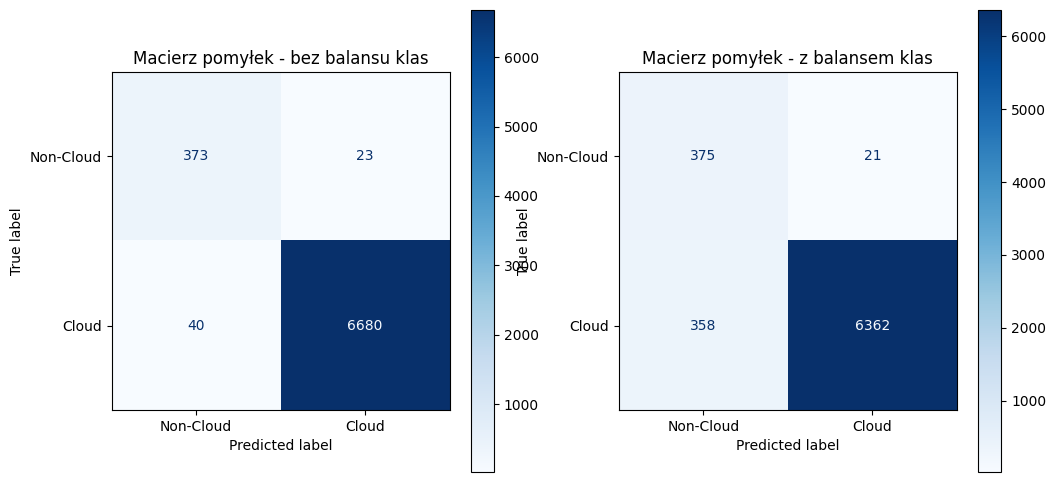

In [79]:
# Wyświetlanie macierzy pomyłek
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(cm_unbalanced, display_labels=['Non-Cloud', 'Cloud']).plot(ax=ax[0], cmap='Blues')
ax[0].set_title('Macierz pomyłek - bez balansu klas')
ConfusionMatrixDisplay(cm_balanced, display_labels=['Non-Cloud', 'Cloud']).plot(ax=ax[1], cmap='Blues')
ax[1].set_title('Macierz pomyłek - z balansem klas')
plt.show()

In [80]:
# Funkcja do wyświetlania krzywych uczenia
def plot_learning_curves(history, title='Learning Curves'):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

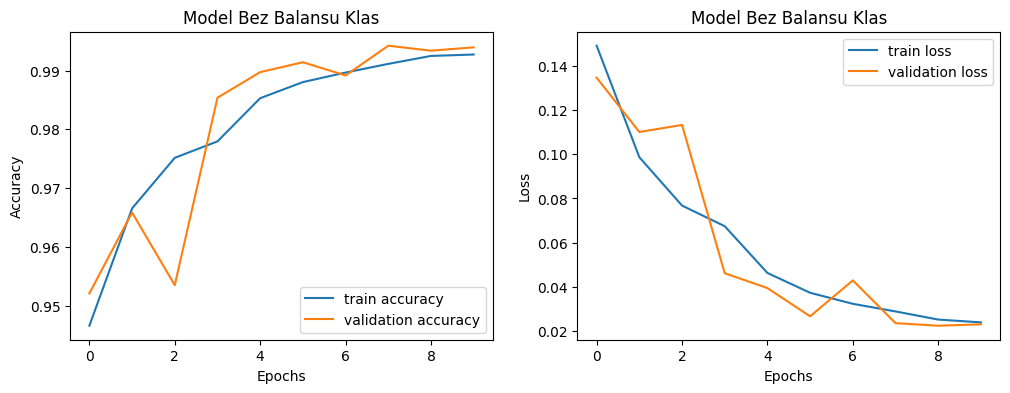

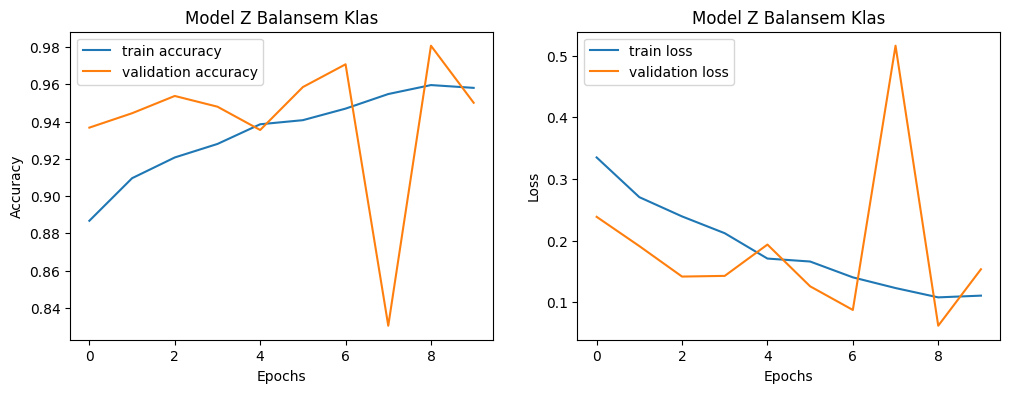

In [82]:
# Wyświetlenie krzywych uczenia dla obu modeli
plot_learning_curves(history, 'Model Bez Balansu Klas')
plot_learning_curves(history_balanced, 'Model Z Balansem Klas')

Obserwacje: 
można zauważyć, że model bez balansu klasowego osiągnął wyższą skuteczność klasyfikacji - ponad 99%. Istotny jest też przebieg procesu nauki. Na wygenerowanych wykresach można zauważyć, że wraz z kolejnymi epokami skuteczność wzrastała, co świadczy o poprawności podejścia. Niestety, model z balansem klasowym spowodował dużo większą błędną predykcję klasy 1 (cloud) jako 0 (not_cloud). Jest to oczywiście związane z dużo większą wagą i pokazuje, że nie zawsze zapewnienie balansu klasowego za pomocą wag jest słusznym podejściem.

# Podejście dodatkowe - augmentacja danych
W tej części dokonano treningu modelu z augmentacją (losowymi zmianami) danych obrazowych


In [132]:
# Dodawanie augmentacji danych 
# Użyjemy generatora danych. Dokona on augmentacji poprzez rotacje, przesunięcia, zoom oraz zmiany w odcieniach koloru
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator

In [133]:
# Ustawienia augmentacji danych
data_gen = ImageDataGenerator(
    rotation_range=20,  # Rotacja obrazu o maksymalnie 20 stopni
    width_shift_range=0.2, # Przesunięcia w poziomie 
    height_shift_range=0.2, #Przesunięcia w pionie 
    shear_range=0.15, # Pochylenie obrazu 
    zoom_range=0.2, # Zoom
    horizontal_flip=True, # Losowe odbicia lustrzane w poziomie 
    fill_mode="nearest" # Sposób uzupełniania nowych pikseli, które mogą powstać po transformacji
)


In [139]:
#Dodanie trzeciego wymiaru dla kanałów kolorów (1 dla skali szarości), aby generator mógł działać (zgodność wymiarów) 
train_images = np.expand_dims(train_images, axis=-1) 

In [137]:
train_images = np.squeeze(train_images)

In [140]:
# Utworzenie generatorów dla danych treningowych z augmentacją
train_generator = data_gen.flow(train_images, train_labels, batch_size=32)

In [141]:
# Trening modelu z użyciem augmentacji danych
model_with_augmentation = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [142]:
# Kompilacja modelu
model_with_augmentation.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [143]:
# Trenowanie modelu z augmentacją danych
history_with_augmentation = model_with_augmentation.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 32,  # Liczba kroków na epokę, zależna od rozmiaru batcha
    epochs=15,
    validation_data=(val_images, val_labels)
)

Epoch 1/15
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 49s 47ms/step - accuracy: 0.9415 - loss: 0.1977 - val_accuracy: 0.9487 - val_loss: 0.1171
Epoch 2/15
   1/1037 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - accuracy: 1.0000 - loss: 0.0481

2024-05-15 14:53:50.494077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1037/1037 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0481 - val_accuracy: 0.9487 - val_loss: 0.1202
Epoch 3/15
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.9497 - loss: 0.1323 - val_accuracy: 0.9621 - val_loss: 0.1137
Epoch 4/15
   1/1037 ━━━━━━━━━━━━━━━━━━━━ 1:20 78ms/step - accuracy: 1.0000 - loss: 0.0551

2024-05-15 14:54:40.905154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1037/1037 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 0.0551 - val_accuracy: 0.9623 - val_loss: 0.1097
Epoch 5/15
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 53s 51ms/step - accuracy: 0.9533 - loss: 0.1259 - val_accuracy: 0.9608 - val_loss: 0.1168
Epoch 6/15
   1/1037 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - accuracy: 0.9688 - loss: 0.0887

2024-05-15 14:55:36.204853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1037/1037 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9688 - loss: 0.0887 - val_accuracy: 0.9608 - val_loss: 0.1157
Epoch 7/15
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.9563 - loss: 0.1175 - val_accuracy: 0.9646 - val_loss: 0.1101
Epoch 8/15
   1/1037 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 1.0000 - loss: 0.0889

2024-05-15 14:56:25.160893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1037/1037 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0889 - val_accuracy: 0.9657 - val_loss: 0.1088
Epoch 9/15
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.9626 - loss: 0.1067 - val_accuracy: 0.9691 - val_loss: 0.0859
Epoch 10/15
   1/1037 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - accuracy: 1.0000 - loss: 0.0164

2024-05-15 14:57:14.488808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1037/1037 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0164 - val_accuracy: 0.9681 - val_loss: 0.0846
Epoch 11/15
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.9620 - loss: 0.1060 - val_accuracy: 0.9604 - val_loss: 0.1011
Epoch 12/15
   1/1037 ━━━━━━━━━━━━━━━━━━━━ 52s 51ms/step - accuracy: 1.0000 - loss: 0.0299

2024-05-15 14:58:03.738362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1037/1037 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0299 - val_accuracy: 0.9630 - val_loss: 0.0976
Epoch 13/15
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.9672 - loss: 0.0946 - val_accuracy: 0.9760 - val_loss: 0.0699
Epoch 14/15
   1/1037 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - accuracy: 1.0000 - loss: 0.0771

2024-05-15 14:58:52.276619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1037/1037 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0771 - val_accuracy: 0.9760 - val_loss: 0.0700
Epoch 15/15
1037/1037 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.9725 - loss: 0.0856 - val_accuracy: 0.9774 - val_loss: 0.0788


In [144]:
# Ewaluacja modelu
accuracy_with_augmentation = model_with_augmentation.evaluate(test_images, test_labels)[1]
print("Dokładność modelu z augmentacją danych: {:.2f}%".format(accuracy_with_augmentation * 100))

223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9792 - loss: 0.0842
Dokładność modelu z augmentacją danych: 97.44%


In [145]:
#Predykcje
pred_labels_augmentation = (model_with_augmentation.predict(test_images) > 0.5).astype(int)

223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


In [146]:
# Macierz pomyłek 
cm_augmentation = confusion_matrix(test_labels, pred_labels_augmentation)

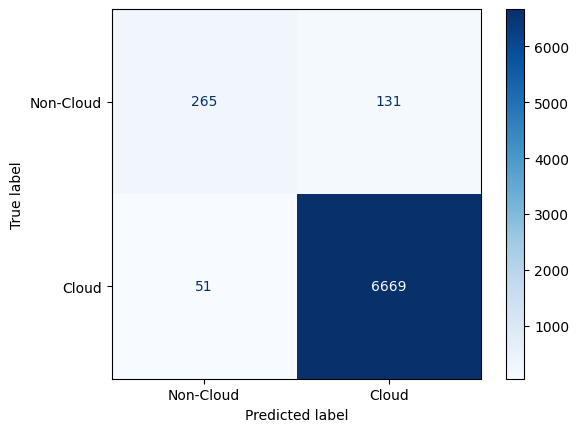

In [147]:
# Macierz pomyłek - wyświetlenie
ConfusionMatrixDisplay(cm_augmentation, display_labels=['Non-Cloud', 'Cloud']).plot(cmap='Blues')
plt.show()

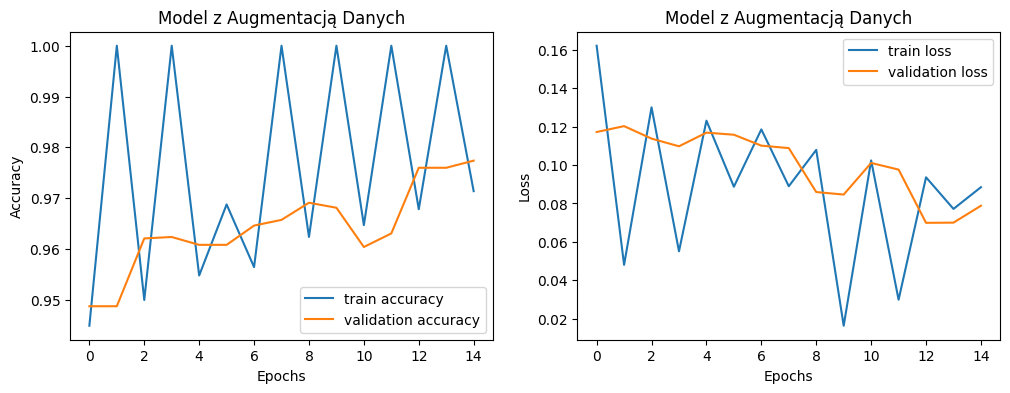

In [148]:
# Wyświetlenie krzywych uczenia dla modelu z augmentacją danych
plot_learning_curves(history_with_augmentation, 'Model z Augmentacją Danych')

In [ ]:
Obserwacje: Można zauważyć, że model porawdził sobie bardzo dobrze. 
Wydużenie treningu wpłynęło na zwiększenie skuteczności klasyfikacji. Dla danych testowycn wyniosła ona ponad 97%. 

# Podsumowanie 
W analizie przetestowano kilka podejść do treningu - brak balansu, balans klasowy z wykorzystaniem przypisania wag dla każdej z klas oraz augmentację danych z generatorem. Najmniej skuteczne okazło się podejście z balansem klas. Przypisanie zbyt dużej wagi dla klasy 0 (non_cloud) spowodowało wiele pomyłek przy klasyfikacji (0 zamiast 1). Wysokie skuteczności osiągnęły modele bez balansu oraz z augmentacją (chociaż tutaj trening był nieco dłuższy). Najlepszy wynik dla danych nie biorących udziału w treningu osiągnięty został przez model bez balansu - skuteczność klasyfikacji na poziomie 99.11%.